# Inference Example 
This notebook dempnstrates how to do inference using the models SFCN, EfficientNet and DenseNet for AD-vs-HC classification. 

By default this notebooks demonstates inference on the IXI dataset, since ADNI is not publicly available.

Make sure that the preprocessing has been done using the `preprocessing.ipynb` notebook.

In [21]:
import torch

from monai.data import DataLoader, Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    Spacingd,
    ResizeWithPadOrCropd,
    ScaleIntensityd,
)

from monai.networks.nets import EfficientNetBN, DenseNet121


from pathlib import Path
import json

from SFCN import SFCN, get_Bb_dims

import numpy as np
import matplotlib.pyplot as plt

In [22]:
fold = 1

model_type = 'SFCN' # 'EfficientNet' or 'Densenet121' or 'SFCN'

pixdim = (1.0, 1.0, 1.0)
img_size = (160, 192, 160)

batch_size = 1
dataloader_workers = 0 # 0 means no subprocesses


In [23]:
static_transform = Compose(
    [
        LoadImaged(keys=['image']),
        EnsureChannelFirstd(keys=['image']),
        CropForegroundd(keys=["image"], source_key="image"),
        Spacingd(keys=['image'], pixdim=pixdim, mode=("bilinear")),
        ResizeWithPadOrCropd(keys=['image'], spatial_size=img_size, mode='constant', value=0.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    ])

In [24]:
# Load the dataset
dataset_path = Path('.')
json_path = dataset_path / 'IXI_preprocessed.json'

with open(json_path, 'r') as f:
    dataset = json.load(f)

# Initialize the dataloader
dataset = Dataset(dataset, transform=static_transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=dataloader_workers)


if model_type == 'EfficientNet':
    model = model = EfficientNetBN("efficientnet-b0", spatial_dims=3, in_channels=1, num_classes=1)
    model_weights_path = Path('model_weights') / f'EfficientNet_AD_fold{fold}.pt'
elif model_type == 'Densenet121':
    DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
    model_weights_path = Path('model_weights') / f'DenseNet_AD_fold{fold}.pt'
elif model_type == 'SFCN':
    model = SFCN(get_Bb_dims(7), 1)
    model_weights_path = Path('model_weights') / f'SFCN_AD_fold{fold}.pt'
else:
    raise ValueError(f'Invalid model type: {model_type}')

weights = torch.load(model_weights_path)
# Load the weights
model.load_state_dict(weights, strict=True, assign=True)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mdoel = model.to(device)


## Do inference on the Dataset and save the results

In [25]:
n_lim = 30 # Number of images to process
images = []
outputs = []

model.eval()

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        image = batch['image'].to(device)

        output = model(image)
        output = torch.sigmoid(output)

        images.append(image.cpu().detach().numpy())
        outputs.append(output[0, 0].cpu().detach().numpy())
        if i >= n_lim:
            break


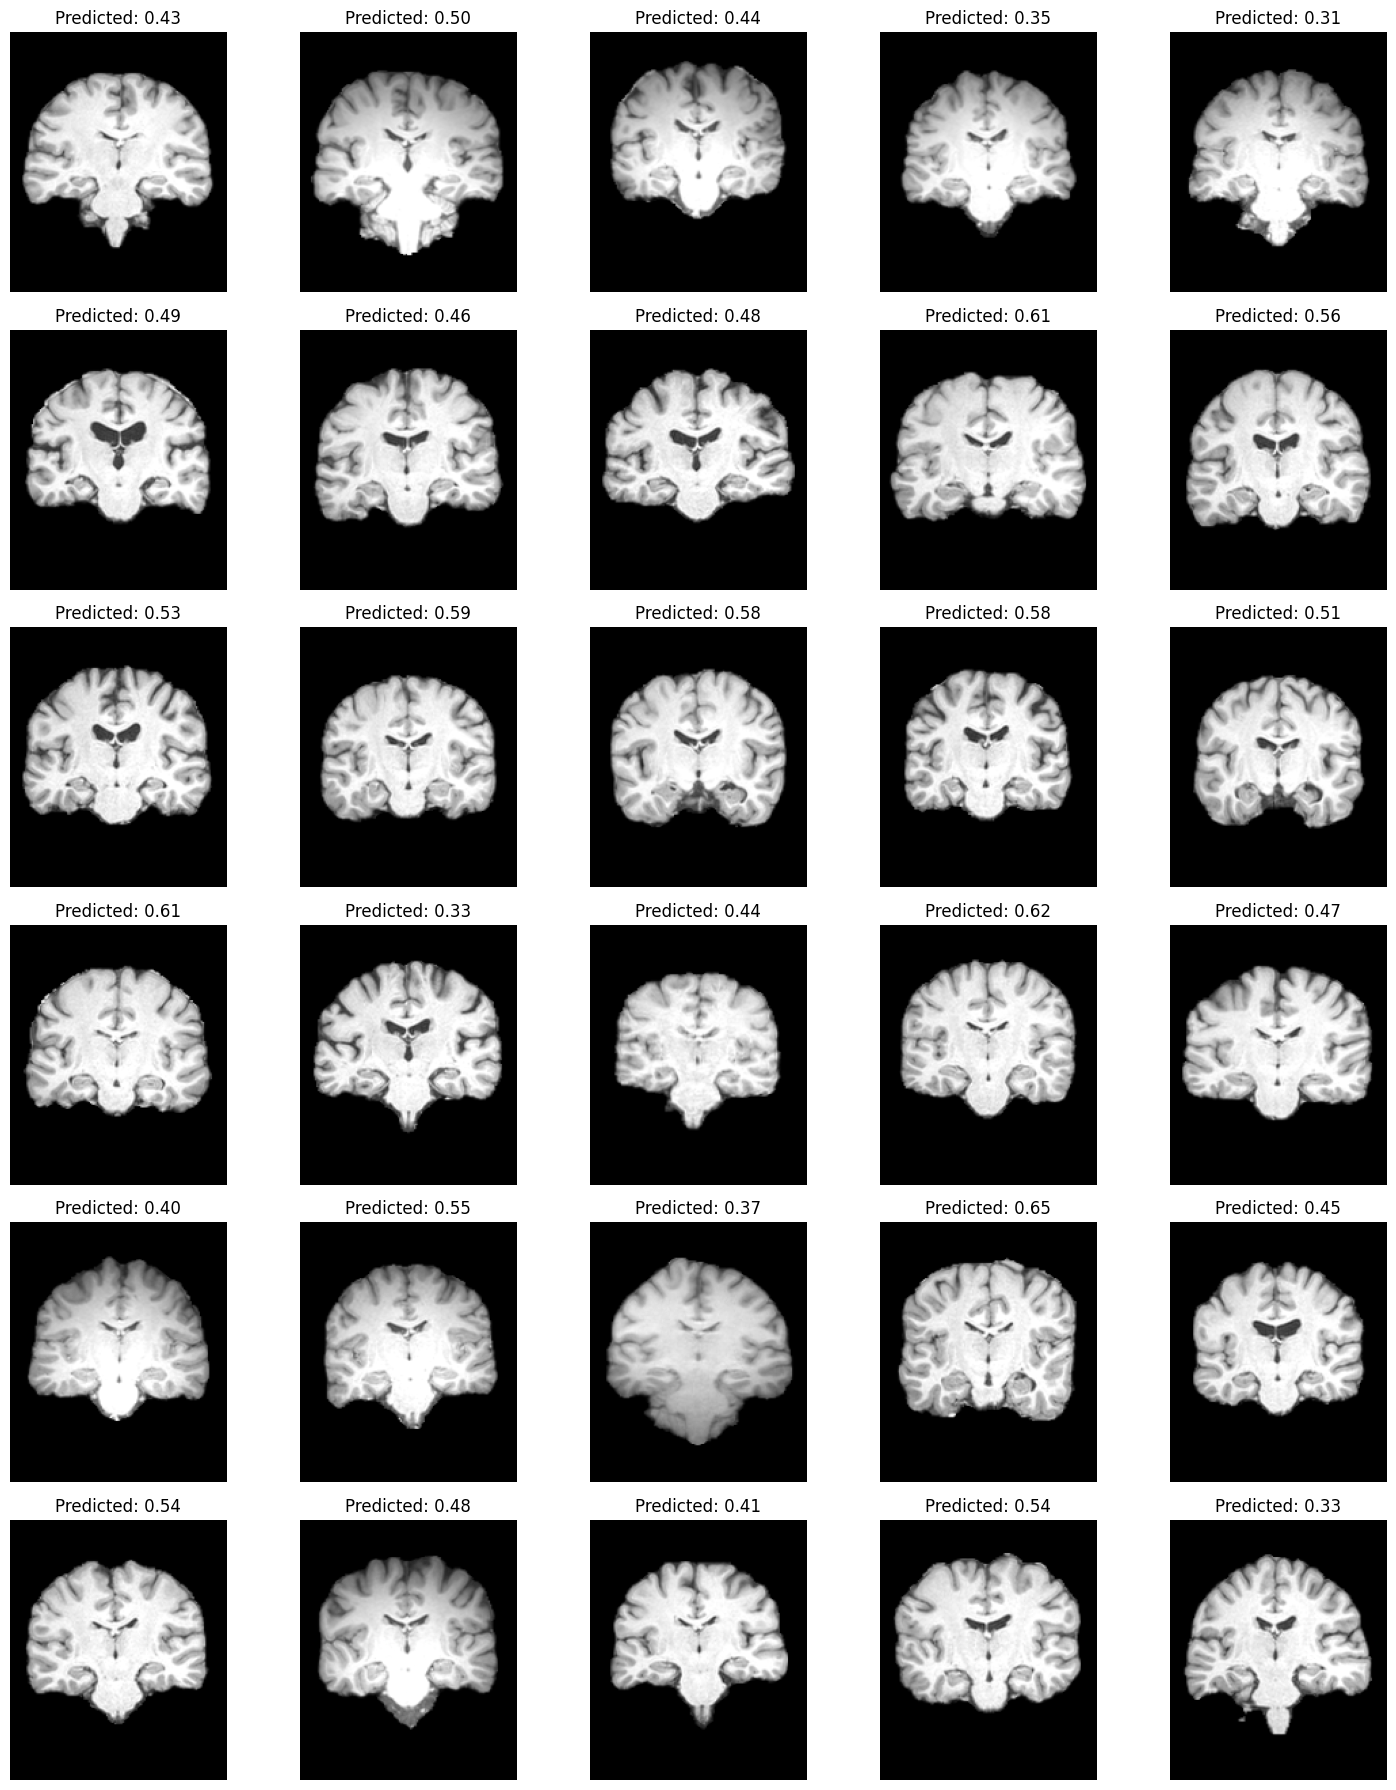

In [26]:
# Plot the images with the predicted labels
cols = 5
rows = (n_lim + cols - 1) // cols  # Calculate the number of rows based on the number of images
fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

for i in range(n_lim):
    if axs.ndim == 1:
        ax = axs[i]
    else:
        ax = axs[i // cols, i % cols]
    img = images[i]
    output = outputs[i]
    image = img[0, 0, 80, :, :]
    image = np.flip(image, axis=0)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Predicted: {output:.2f}')
    ax.axis('off')
    
fig.tight_layout()
